In [2]:
from h2_molecule import *
Precision.PRECISION = 5
Precision.update_threshold()

import pandas as pd
import seaborn as sns

In [4]:
problem_instance = H2MoleculeInstance({0:0}, H2ExperimentID.P0_CliffordT, 14)
initial_state = problem_instance.initial_state[0].to_np_array()

[ 0.99341393+0.j -0.11458085+0.j]


In [16]:
observable = get_hamiltonian(H2ExperimentID.P0_CliffordT)
observable

SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-1.04422589+0.j, -0.77749518+0.j,  0.18177154+0.j])

In [38]:
target_state = schroedinger_equation(observable, complex(0, -14), initial_state)
target_energy = get_energy(observable, target_state)

/Users/stefaniemuroyalei/Documents/ist/im_time_evolution/.env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


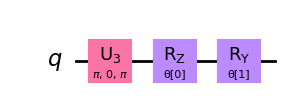

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()

reference_circuit = QuantumCircuit(1)
reference_circuit.x(0)

# two local means that each layer (reps) has quantum gates that operate on at most 2 qubits
variational_form = TwoLocal(
    num_qubits=1,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=0,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [32]:
from qiskit.primitives import Estimator
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    assert isinstance(estimator, Estimator)
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([ansatz], [hamiltonian], [params]).result().values[0]
    return cost

In [15]:
from qiskit.primitives import Estimator
estimator = Estimator()

In [44]:
from scipy.optimize import minimize

x0 = np.ones(2)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.8426866680567455
       x: [ 1.000e+00  2.912e+00]
     nit: 5
     jac: [ 0.000e+00  1.487e-04]
    nfev: 16
    njev: 5

In [41]:
print("target energy:", target_energy)
print("found energy:", result.fun)

target energy: -1.8426866819057302
found energy: -1.8426866680567455


In [60]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.aer import AerSimulator
param_dict = dict(zip(variational_form.parameters, result.x))

# Step 5: Bind the parameter values to the circuit
bound_ansatz = ansatz.bind_parameters(param_dict)

bound_ansatz.save_statevector('res', pershot=True)

# Step 6: Simulate the quantum state using a statevector simulator
simulator = AerSimulator(method='statevector')
tqc = transpile(bound_ansatz, simulator)
result2 = simulator.run(tqc).result()
# Step 7: Get the quantum state as a Statevector object
quantum_state = result2.data()['res']

# Step 8: Convert the Statevector to a NumPy array
state_as_array = np.array(quantum_state)[0]

# Step 9: Print the quantum state as a NumPy array
print(state_as_array)

[-0.8718121 -0.47627311j  0.10047297+0.05488863j]


/var/folders/jb/g9mmpv8n62190fgx4t722rnr0000gn/T/ipykernel_75261/2458446267.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_ansatz = ansatz.bind_parameters(param_dict)


In [61]:
get_fidelity(target_state, state_as_array)

0.7701511545491301

In [63]:
print(bound_ansatz)

   ┌───┐┌────────────────────┐ res 
q: ┤ X ├┤ TwoLocal(1,2.9121) ├──░──
   └───┘└────────────────────┘  ░  


In [65]:
target_energy

-1.8426866819057302

In [68]:
get_energy(observable, state_as_array)

-1.842686668056745